# A Empresa Cardio Catch Diseases ( CCD )

Cadio Catch Diseases is a company that specializes in detecting heart disease in the early stages. Its business model is of the Service type, that is, the company offers the early diagnosis of a cardiovascular disease for a certain price.

Currently, the diagnosis of a cardiovascular disease is done manually by a team of specialists. The current accuracy of the diagnosis varies between 55% and 65%, due to the complexity of the diagnosis and also the fatigue of the team that takes turns to minimize the risks. The cost of each diagnosis, including the equipment and the analysts payroll, is around 1,000.00.

The price of the diagnosis, paid by the client, varies according to the precision achieved by the team of specialists. The client pays 500.00. for every 5% of accuracy above 50%. For example, for an accuracy of 55%, the diagnosis costs 500.00 for the customer, for an accuracy of 60%, the value is 1000.00. If the diagnostic accuracy is 50%, the customer does not pay for it.

Note that the variation in the precision given by the team of specialists causes the company to have either an operation with profit, revenue greater than cost, or an operation with a loss, revenue less than cost. This diagnostic instability causes the company to have an unpredictable Cashflow.

The goal as a Data Scientist employed by Cardio Catch Diseases is to create a tool that increases diagnostic accuracy and that accuracy is stable for all diagnoses. Therefore, the job is to create a patient classification tool with stable accuracy. Along with the tool, you need to send a report to the CEO of Cardio Catch Diseases, reporting the results and answering the following questions: ( He will likely ask these questions on the day of your presentation. )

- What is the Accuracy and Precision of the tool?
- How much profit will Cardio Catch Diseases make with the new tool?
- What is the reliability of the result given by the new tool?

**Information about the dataset**

The dataset that will be used to create the solution for Cardio Catch Diseases is available on the Kaggle platform.
This dataset contains 70,000 patient diagnoses.

The link: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

# Business Problem

The challenge is to help the company in detecting heart diseases in the early stages. The business model is 'sevice', it means that the company offers an early heart disease diagnostic for a price.
Important details:<br>
- Actually, the precision of the diagnostic is between 55% and 65%.
- For each 5% of increasement in accuracy above 50%, the price receives an increase of R$ 500,00.

## Main goal:

Create a tool tha increases diagnostic accuracy, that this accuracy is stable for all diagnostics.

## Secondary goals:

Answer the CEO questions:
1. What is the accuracy and precision of the tool?
2. How much profit the company will have with the new tool?
3. How reliable is the result given by the new tool?

## Strategy guide:
**1.** Collect and load the data;

**2.** Data preparation;
- Check for missing values
- Check the relevance of each feature
- See the statistical metrics of each feature

**3.** Exploratory Data Analysis
- Check the distribution of the attributes
- Treat Outliers
- Filter relevant rows to the case
- Univariate and bivariate analysis

**4.** Hypotheses (Verify with T Test of Student)
- 4.1 Does the 'age' feature affect the number of cases of cardiovascular disease? **Answer: Yes**
- 4.2 Does the 'weight' feature affect the number of cases of cardiovascular disease? **Answer: Yes**
- 4.3 Does the 'ap_hi' feature affect the number of cases of cardiovascular disease? **Answer: Yes**
- 4.4 Does the 'height' feature affect the number of cases of cardiovascular disease? **Answer: Yes**

**5.** Feature Engineering

**6.** Encoding of categorical variables (One-hot-enconding)

**7.** Machine Learning Prediction Model
- Choose the best model between: LogisticRegression, RandomForests and Light-GBM
- Use the cross-validation: n = 5 models
- Translate of the models performance to the business performance

**8.** Deploy

# 0.0 General Imports & Helper Functions

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from yellowbrick.classifier.threshold import discrimination_threshold
from sklearn.ensemble       import RandomForestClassifier
from lightgbm import LGBMClassifier



# Notebook config
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams.update({'font.size': 12})

In [2]:
# Definition of limit inferior/superior
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5*amplitude, q3 + 1.5*amplitude


# Remove Outliers
def remove_outliers(df, coluna):
    row_before = df.shape[0]
    lim_inf, lim_sup = limites(df['age_years'])
    df = df.loc[(df[coluna] >= lim_inf) & (df[coluna] <= lim_sup)]
    row_removed = row_before - df.shape[0]
    return df, row_removed    


# Significant difference test
def diff_test(*samples):
    ''' If two grups are being evaluating, a T Student Test will be aplied.
        If three or more groups are being evaluating, a one way ANOVA will be aplied.'''
    samples = samples
    try:
        if len(samples) == 2:
            stat, p = ttest_ind(*samples)
        elif len(samples) > 2:
            stat, p = f_oneway(*samples)
    except:
        raise Exception('Please, inform two samples at least!')
        
    if p < 0.05:
        print(f'The p value is less than 0.05: {p}.')
        print(f'There is a significant difference between the mean of samples.')
    else:
        print(f'The p value is greater than 0.05: {p}.')
        print(f'There is no significant difference between the mean of samples.')
    return stat, p


# Creating the column 'blood_pressure'
def blood(df):
    if df['ap_hi'] < 90 and df['ap_lo'] < 60:
        return 1
    elif 90 <= df['ap_hi'] < 140 and 60 <= df['ap_lo'] < 90:
        return 2
    elif 140 <= df['ap_hi'] < 160 and 90 <= df['ap_lo'] < 100:
        return 3
    elif df['ap_hi'] >= 160 and df['ap_lo'] >= 100:
        return 4
    else:
        return 5    

# 1.0 Load the data

In [3]:
df_raw = pd.read_csv('dataset/cardio_train.csv', sep=';')
df_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# 2.0 Data preparation

In [4]:
df = df_raw.copy()

# Check the shape of the dataset
print(f'The number of columns is {df.shape[1]}.')
print(f'The number of rows is {df.shape[0]}')

The number of columns is 13.
The number of rows is 70000


In [5]:
# Details of the data
pd.DataFrame({'%missing': df.isna().mean(),                              # percentual of missing values
              'uniques': df.nunique(),                                   # number of unique values
              '%unique': round((df.nunique()/df.shape[0])*100, 2),       # percentual of unique values
              'data_types': df.dtypes,
              'mean': round(df.mean(), 2),
              'median': round(df.median(), 2),
              'std': round(df.std(), 2),
              'min': round(df.min(), 2),
              'max': round(df.max(), 2)})

,%missing,uniques,%unique,data_types,mean,median,std,min,max
id,0.0,70000,100.00,int64,49972.42,50001.5,28851.30,0.0,99999.0
age,0.0,8076,11.54,int64,19468.87,19703.0,2467.25,10798.0,23713.0
gender,0.0,2,0.00,int64,1.35,1.0,0.48,1.0,2.0
height,0.0,109,0.16,int64,164.36,165.0,8.21,55.0,250.0
weight,0.0,287,0.41,float64,74.21,72.0,14.40,10.0,200.0
ap_hi,0.0,153,0.22,int64,128.82,120.0,154.01,-150.0,16020.0
ap_lo,0.0,157,0.22,int64,96.63,80.0,188.47,-70.0,11000.0
cholesterol,0.0,3,0.00,int64,1.37,1.0,0.68,1.0,3.0
gluc,0.0,3,0.00,int64,1.23,1.0,0.57,1.0,3.0
smoke,0.0,2,0.00,int64,0.09,0.0,0.28,0.0,1.0


## 2.1 - Considerations of data preparation:

- The feature 'age' is in days. We will divide it by 365 and check if the values make sense.
- We will drop the column 'id', it's not relevant to our case.
- No need the enconding method for the categorical variables (already numeric values).
- Our target variable is 'cardio', that is, presence or absense of cardiovascular disease [Binary classification problem].
- We don't have any missing values.

In [6]:
# Age in years
df['age_years'] = df['age'] / 360

# Drop the columns 'id' and 'age'
df.drop(['id','age'], axis='columns', inplace=True)
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,2,168,62.0,110,80,1,1,0,0,1,0,51.091667
1,1,156,85.0,140,90,3,1,0,0,1,1,56.188889
2,1,165,64.0,130,70,3,1,0,0,0,1,52.380556
3,2,169,82.0,150,100,1,1,0,0,1,1,48.952778
4,1,156,56.0,100,60,1,1,0,0,0,0,48.538889


# 3.0 Exploratory Data Analysis

- Check feature by feature:
    1. See the correlation between features and decide if we keep all of it; (if there's a huge correlation, we can discard one of the pair of features)
    2. Exclude Outliers (Rule == up to Q3 + 1.5xA & down to Q1 + 1.5xA) A = Q3 - Q1
    3. Confirm if all of the features make sense to our model;

## 3.1 Correlation between features

In [7]:
# Correlation map
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
gender,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109,-0.022811
height,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821,-0.081515
weight,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660,0.053684
ap_hi,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475,0.020764
ap_lo,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719,0.017647
cholesterol,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147,0.154424
gluc,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307,0.098703
smoke,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486,-0.047633
alco,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476,-0.007330,-0.029723
active,0.005866,-0.006570,-0.016867,-0.000033,0.004780,0.009911,-0.006770,0.025858,0.025476,1.000000,-0.035653,-0.009927


## 3.2 Univariate Analysis

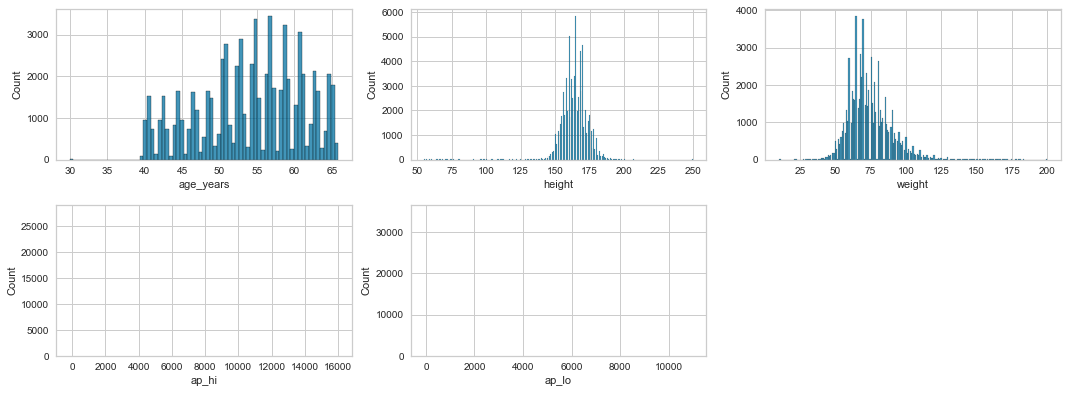

In [8]:
# Checking  the numeric variables - histogram
numeric_vars = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']
plt.figure(figsize=(18,10))
n = 1
for column in numeric_vars:
    plt.subplot(3, 3, n)
    sns.histplot(x=df[column])
    n += 1
plt.subplots_adjust(hspace=0.3)
plt.show()

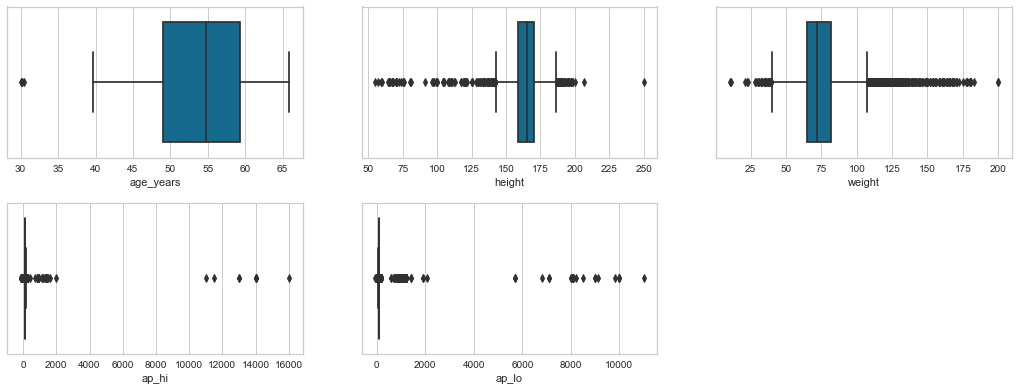

In [9]:
# Checking  the numeric variables - box-plot
plt.figure(figsize=(18,10))
n=1
for column in numeric_vars:
    plt.subplot(3,3,n)
    sns.boxplot(x=df[column])
    n += 1
plt.subplots_adjust(hspace=0.3)
plt.show()

### 3.2.1 'cardio'

- We can check that in the target feature does not need to be used  any technique of balancing.

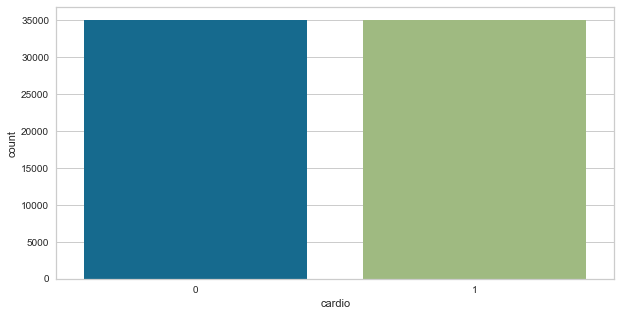

In [10]:
# Checking the balance of the feature with a bar plot
plt.figure(figsize=(10,5))
ax = sns.countplot(x=df['cardio'])
plt.show()

### 3.2.1 'age_years'
- We can notice that the positive condition to heart disease can be related to older people.

count    70000.000000
mean        54.080183
std          6.853477
min         29.994444
25%         49.066667
50%         54.730556
75%         59.241667
max         65.869444
Name: age_years, dtype: float64


<Figure size 1080x360 with 0 Axes>

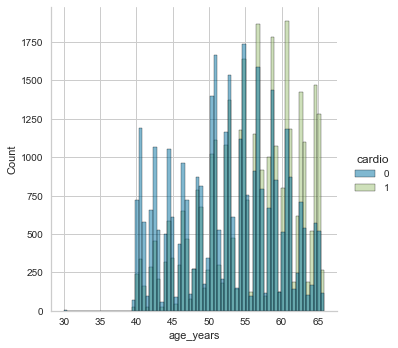

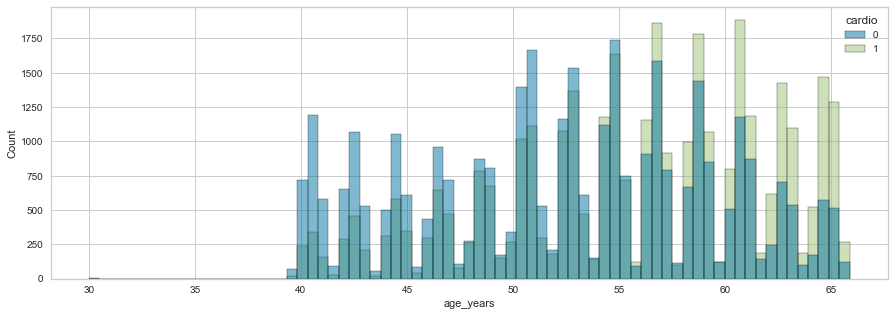

In [11]:
# Checking the minimun age
print(df['age_years'].describe())

# Plot distribution
    # 1st way to do
plt.figure(figsize=(15,5))
ax = sns.displot(x=df['age_years'], hue=df['cardio'], kind='hist')
plt.show()

    # 2nd way to do
plt.figure(figsize=(15,5))
ax = sns.histplot(x=df['age_years'], hue=df['cardio'])
plt.show()

In [12]:
# Remove the outliers?
df, linhas_excluidas = remove_outliers(df, 'age_years')
print(f'Were removed {linhas_excluidas} rows of your dataframe.')
print(df.shape)

Were removed 4 rows of your dataframe.
(69996, 12)


### 3.2.1 'height'
- We can notice a height of 250 cm, which can be a mistake, since the data is collect manually. We will drop the values above 210.
- The minimum age of our data is 30 years. Then the lowest person of our data can be related to a dwarf condition, in which height varies between 112 and 145cm. We will drop the values below 112.

count    69996.000000
mean       164.359063
std          8.210122
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64


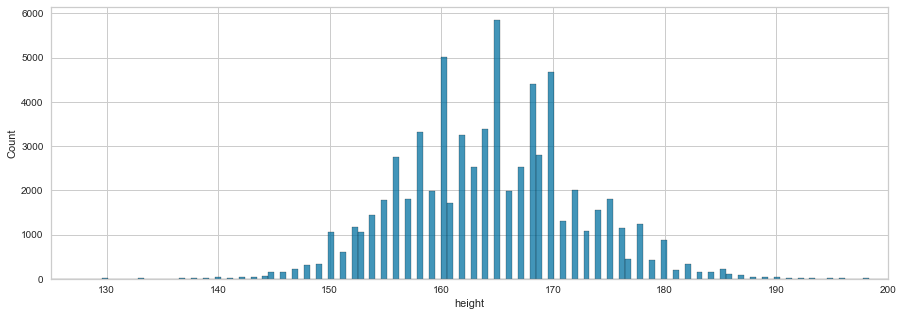

In [13]:
# Checking the minimun and maximum height
print(df['height'].describe())
plt.figure(figsize=(15,5))
ax = sns.histplot(x=df['height'])
ax.set_xlim([125,200])
plt.show()

In [14]:
# Applying the filters
df = df.loc[(df['height'] >= 112) & (df['height'] <= 210)]
df.shape

(69948, 12)

### 3.2.1 'weight'
- We can check that the high values of 'weight' could be relevant for cardio diseases (obesity).
- It was decided to remove the weights lower than 40 kg, what can be linked to some error.

count    69948.000000
mean        74.200688
std         14.372039
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64


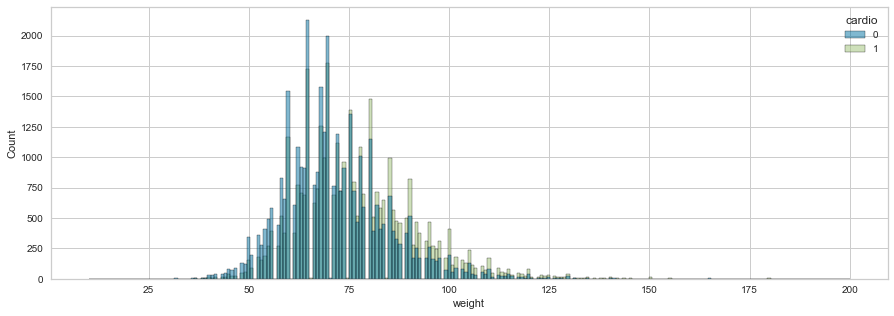

In [15]:
# Checking the minimun weight
print(df['weight'].describe())
plt.figure(figsize=(15,5))
ax = sns.histplot(x=df['weight'], hue=df['cardio'])
plt.show()

In [16]:
# Applying the filter
df = df.loc[(df['weight']>= 40)]
df.shape

(69896, 12)

### 3.2.1 'ap_hi'
- Researching a bit, we can check that unusual readings of Systolic blood pressure are below 10 and above 220.
- Also, when people manually take a note about the pressure, they could write 19000, instead of 190.0
- Therefore, it was decided to divide by 100, cases > 220. Then drop the cases < 10, as weel as cases > 220 after the filter.
- After that, we can notice that high systolic blood pressure could be related to the presence of a heart disease.

count    69896.000000
mean       128.833810
std        154.122418
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64


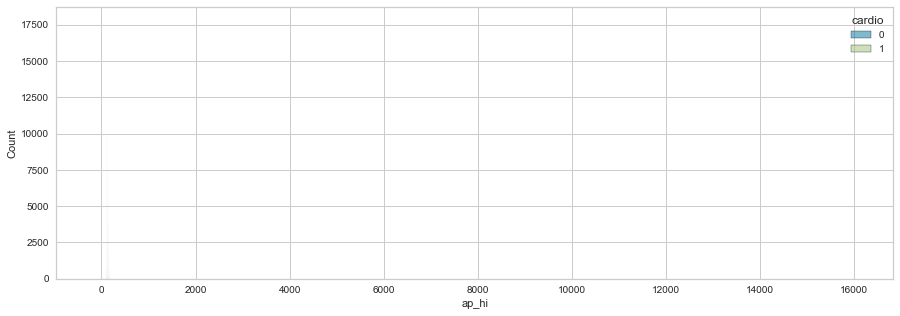

In [17]:
# Checking the minimun and maximum
print(df['ap_hi'].describe())
plt.figure(figsize=(15,5))
ax = sns.histplot(x=df['ap_hi'], hue=df['cardio'])
plt.show()

In [18]:
# Checking how many observations out of range
print(df.loc[df['ap_hi']>220].size)
print(df.loc[df['ap_hi']<10].size)

576
120


In [19]:
# Droping ther data out of range
df = df.loc[(df['ap_hi']<=220) & (df['ap_hi']>=10)]
df.shape

# ||| Reexecute the plot |||

(69838, 12)

### 3.2.1 'ap_lo'
- Researching a bit, we can check that unusual readings of Diastolic blood pressure are below 5 and above 190.
- Also, when people manually take a note about the pressure, they could write 19000, instead of 190.0
- Therefore, it was decided to divide by 100, cases > 190. Then drop the cases < 5, as weel as cases > 190 after the filter.


count    69838.000000
mean        96.593645
std        188.397397
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64


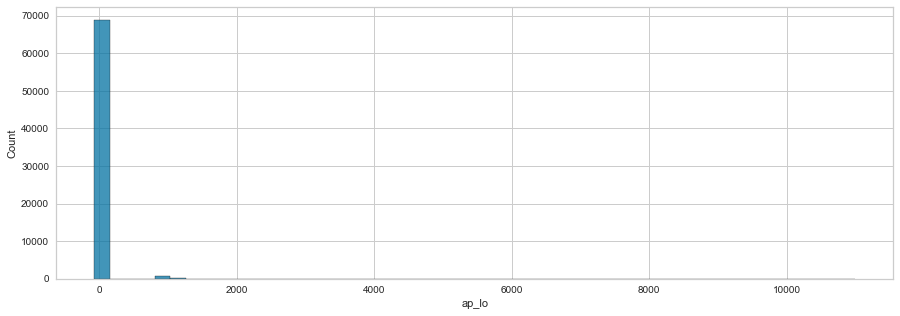

In [20]:
print(df['ap_lo'].describe())
plt.figure(figsize=(15,5))
sns.histplot(x=df['ap_lo'], bins=50)
plt.show()

In [21]:
# Checking how many observations out of range
print(df.loc[df['ap_lo']>190].size)
print(df.loc[df['ap_lo']<5].size)

11376
192


In [22]:
# Divide the observations above 190 by 10
df['ap_lo'] = df['ap_lo'].apply(lambda x: x / 10 if x > 190 else x)
# Or: df.loc[df['ap_lo'] > 190, ['ap_lo']] = df.loc[df['ap_lo'] > 190, ['ap_lo']]/10

# Checking how many observations out of range
print(df.loc[df['ap_lo']>190].size)
print(df.loc[df['ap_lo']<5].size)

288
192


In [23]:
# Droping the observations out of range
df = df.loc[(df['ap_lo'] >= 5)  & (df['ap_lo'] <= 190)]
df.shape


# ||| Reexecute the plot |||

(69798, 12)

## 3.3 Bivariate Analysis

- At this section we will try to get ideas about the correlation of cardio and other 2 numerical variable.


### 3.3.1 Numerical Variables
- it seems to have some positive correlation about cardio and ap_lo, ap_hi, age and weight.

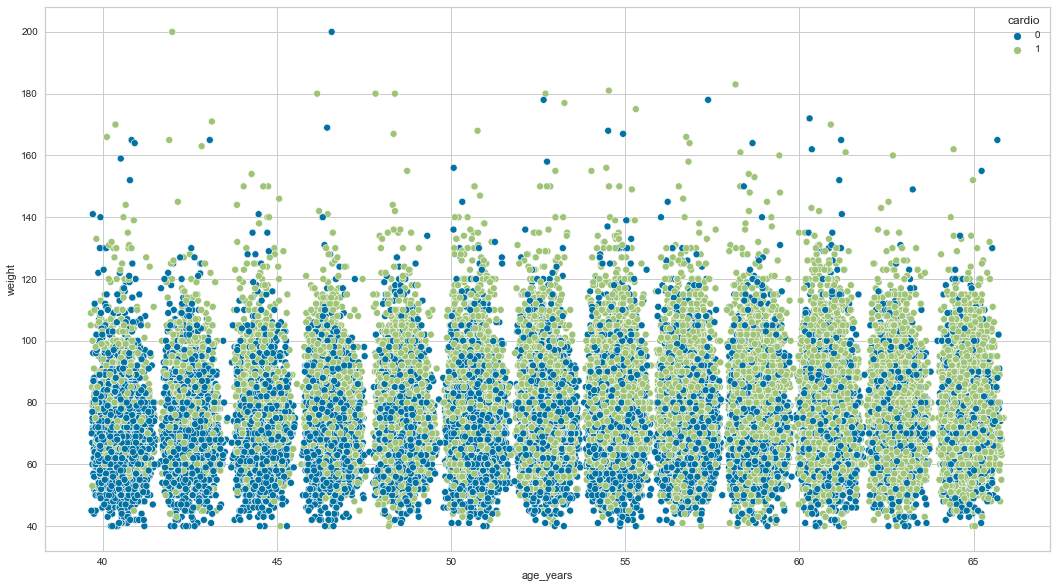

In [24]:
# Scatter-Plot: age_years | weight
plt.figure(figsize=(18,10))
sns.scatterplot(x=df['age_years'], y=df['weight'], hue=df['cardio']);

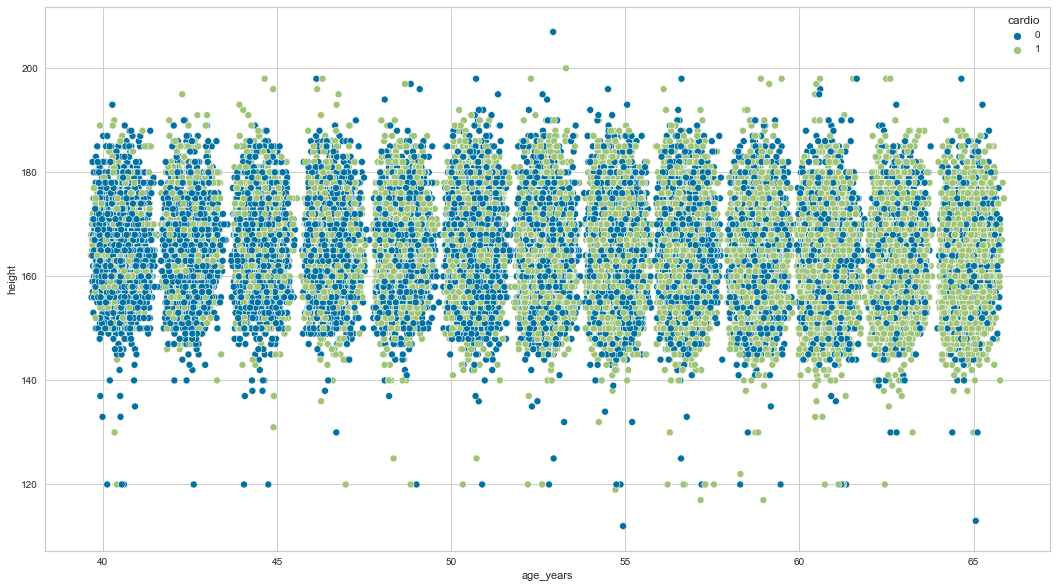

In [25]:
# Scatter-Plot: age_years | height
plt.figure(figsize=(18,10))
sns.scatterplot(x=df['age_years'], y=df['height'], hue=df['cardio']);

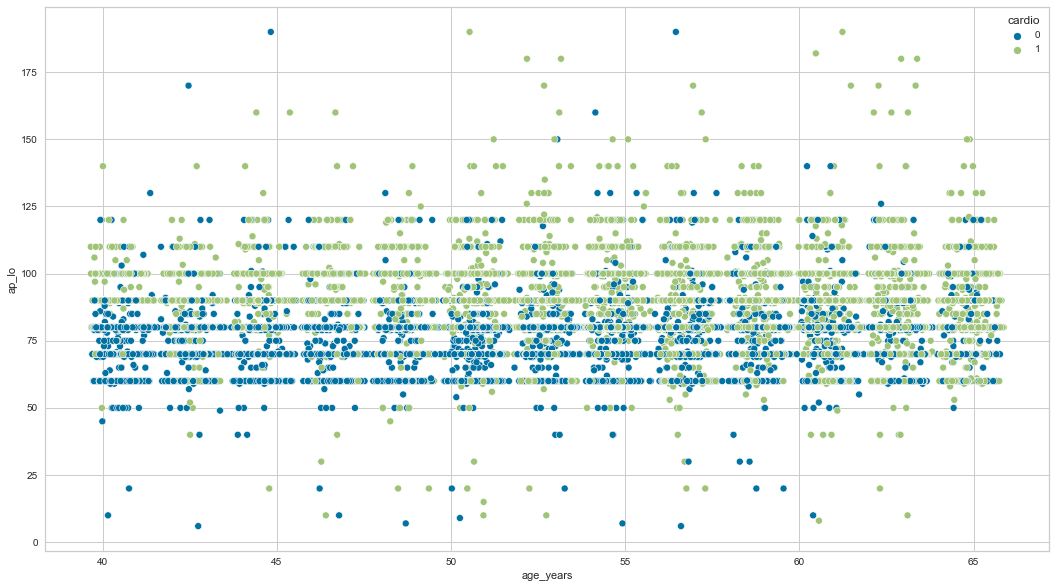

In [26]:
# Scatter-Plot: age_years | ap_lo
plt.figure(figsize=(18,10))
sns.scatterplot(x=df['age_years'], y=df['ap_lo'], hue=df['cardio']);

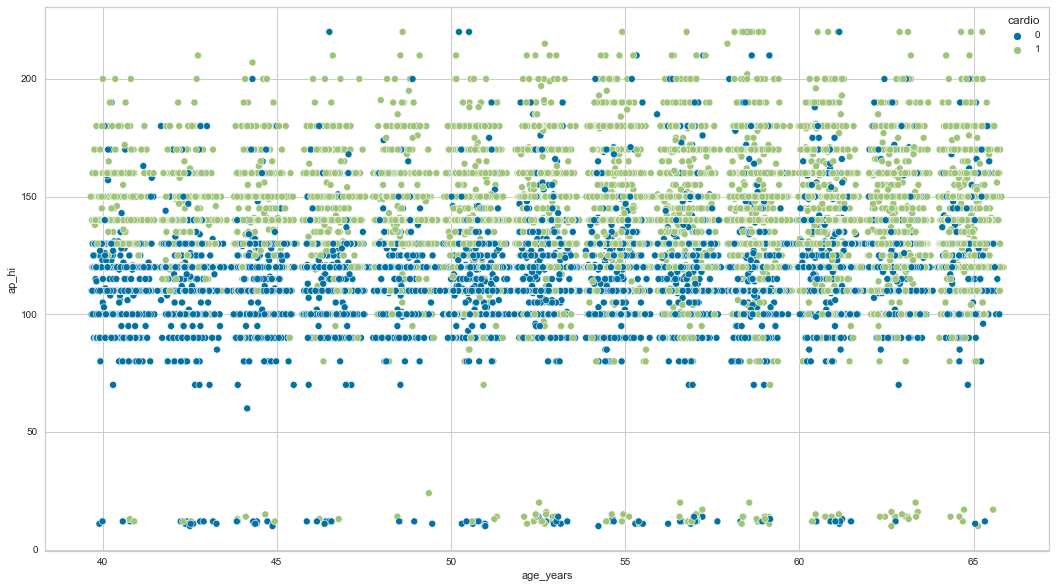

In [27]:
# Scatter-Plot: age_years | ap_hi
plt.figure(figsize=(18,10))
sns.scatterplot(x=df['age_years'], y=df['ap_hi'], hue=df['cardio']);

### 3.3.2 Categorical variables
- No insights in 'cholesterol';
- No insights in 'gender';
- No insights in 'gluc';
- No insights in 'smoke';
- No insights in 'alco';

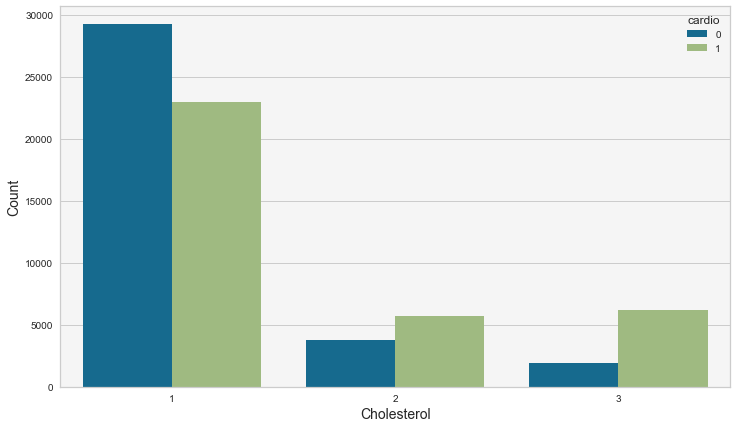

In [28]:
# Checking categorical variables: cholesterol
plt.figure(figsize=(12,7))
ax = sns.countplot(x=df['cholesterol'], hue=df['cardio'])
ax.set_xlabel('Cholesterol', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.show()

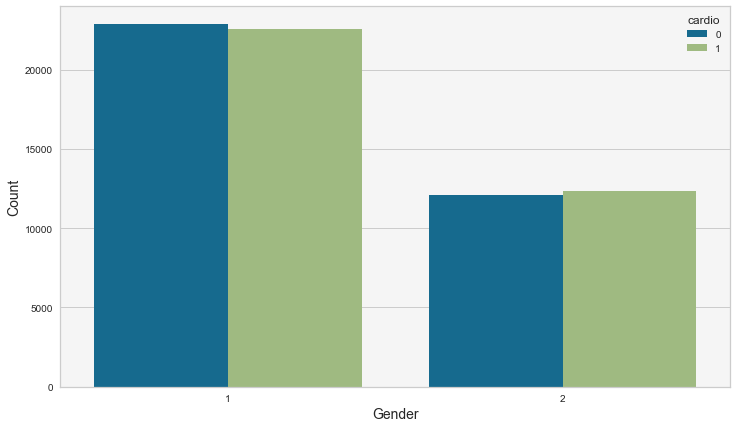

In [29]:
# Checking categorical variables: gender
plt.figure(figsize=(12,7))
ax = sns.countplot(x=df['gender'], hue=df['cardio'])
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.show()

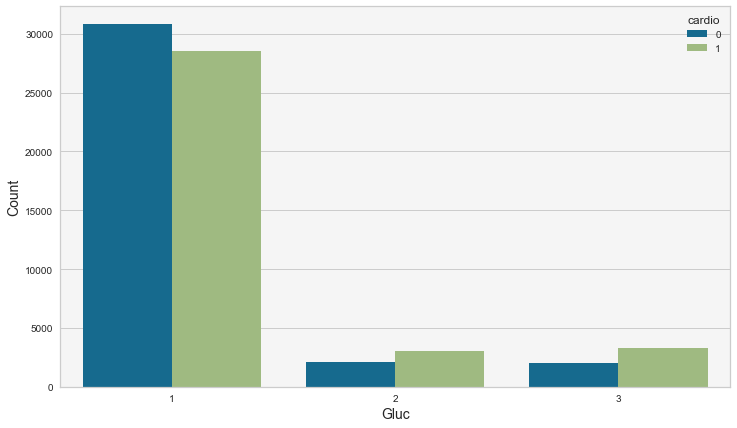

In [30]:
# Checking categorical variables: gluc
plt.figure(figsize=(12,7))
ax = sns.countplot(x=df['gluc'], hue=df['cardio'])
ax.set_xlabel('Gluc', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.show()

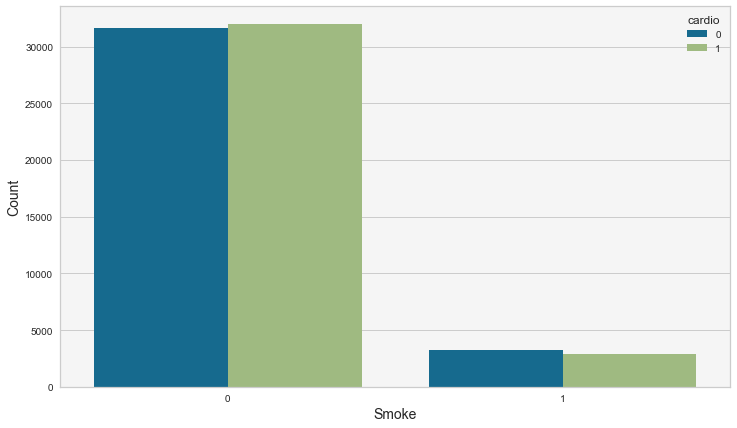

In [31]:
# Checking categorical variables: smoke
plt.figure(figsize=(12,7))
ax = sns.countplot(x=df['smoke'], hue=df['cardio'])
ax.set_xlabel('Smoke', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.show()

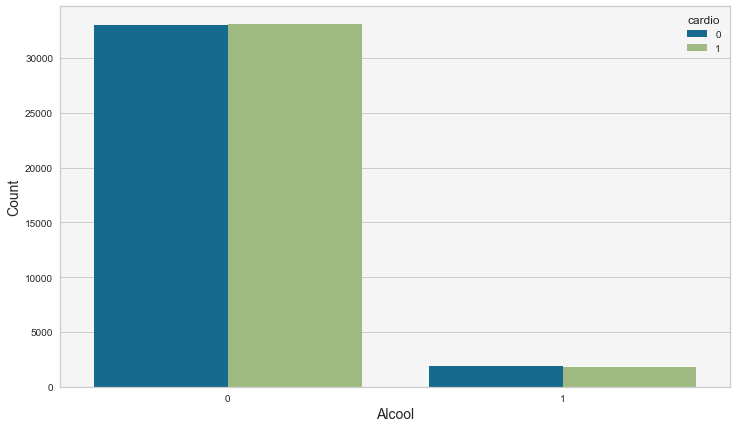

In [32]:
# Checking categorical variables: alco
plt.figure(figsize=(12,7))
ax = sns.countplot(x=df['alco'], hue=df['cardio'])
ax.set_xlabel('Alcool', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.show()

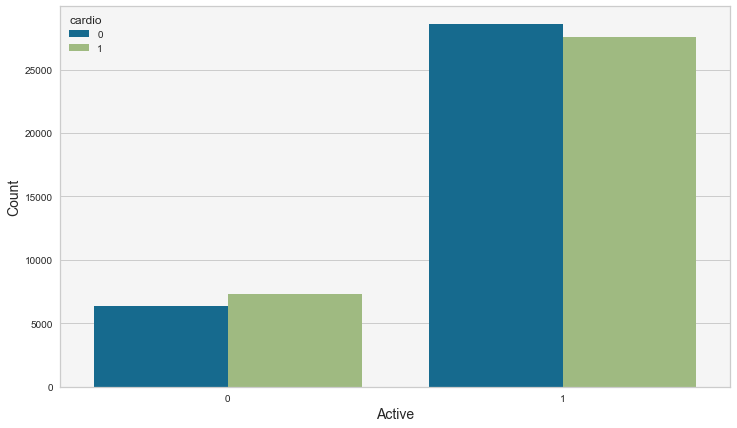

In [33]:
# Checking categorical variables: active
plt.figure(figsize=(12,7))
ax = sns.countplot(x=df['active'], hue=df['cardio'])
ax.set_xlabel('Active', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_facecolor('whitesmoke')
plt.show()

# 4.0 Hypotesis test

1. Does the 'age' feature affect the number of cases of cardiovascular disease?
2. Does the 'weight' feature affect the number of cases of cardiovascular disease?
3. Does the 'ap_hi' feature affect the number of cases of cardiovascular disease?
4. Does the 'height' feature affect the number of cases of cardiovascular disease?

## 4.1 T Test of Student 'age_years'

- Application of TTEST of library scipy.stats. Calculate the T-test for the means of two independent samples of scores. This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values.
- Result: There is a significant difference between the mean of samples. It means that 'age_years' is correlated with the cardio conditions disease.

In [34]:
# Means of the 2 cardio conditions
sample_class0 = df.loc[df['cardio']==0, 'age_years']
sample_class1 = df.loc[df['cardio']==1, 'age_years']

print(f'The mean to class 0: {np.mean(sample_class0)}.')
print(f'The mean to class 1: {np.mean(sample_class1)}.')

# Is this difference really significant?

The mean to class 0: 52.450442000553736.
The mean to class 1: 55.714688193827826.


In [35]:
# Checking the significant difference
diff_test(sample_class0, sample_class1)

The p value is less than 0.05: 0.0.
There is a significant difference between the mean of samples.


(-64.8094478325337, 0.0)

## 4.2 T Test of Student 'weight'

- Application of TTEST of library scipy.stats. Calculate the T-test for the means of two independent samples of scores. This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values.
- Result: There is a significant difference between the mean of samples. It means that 'weight' is correlated with the cardio conditions disease.

In [36]:
# Means of the 2 cardio conditions
sample_class0 = df.loc[df['cardio']==0, 'weight']
sample_class1 = df.loc[df['cardio']==1, 'weight']

print(f'The mean to class 0: {np.mean(sample_class0)}.')
print(f'The mean to class 1: {np.mean(sample_class1)}.')

# Is this difference really significant?

The mean to class 0: 71.62845175702378.
The mean to class 1: 76.8419082021731.


In [37]:
# Checking the significant difference
diff_test(sample_class0, sample_class1)

The p value is less than 0.05: 0.0.
There is a significant difference between the mean of samples.


(-48.856333306281314, 0.0)

## 4.3 T Test of Student 'ap_hi'

- Application of TTEST of library scipy.stats. Calculate the T-test for the means of two independent samples of scores. This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values.
- Result: There is a significant difference between the mean of samples. It means that 'ap_hi' is correlated with the cardio conditions disease.

In [38]:
# Means of the 2 cardio conditions
sample_class0 = df.loc[df['cardio']==0, 'ap_hi']
sample_class1 = df.loc[df['cardio']==1, 'ap_hi']

print(f'The mean to class 0: {np.mean(sample_class0)}.')
print(f'The mean to class 1: {np.mean(sample_class1)}.')

# Is this difference really significant?

The mean to class 0: 119.41458315433744.
The mean to class 1: 134.01809007769273.


In [39]:
# Checking the significant difference
diff_test(sample_class0, sample_class1)

The p value is less than 0.05: 0.0.
There is a significant difference between the mean of samples.


(-117.65096132900312, 0.0)

## 4.4 T Test of Student 'height'

- Application of TTEST of library scipy.stats. Calculate the T-test for the means of two independent samples of scores. This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values.
- Result: There is a significant difference between the mean of samples. It means that 'height' is correlated with the cardio conditions disease.

In [40]:
# Means of the 2 cardio conditions
sample_class0 = df.loc[df['cardio']==0, 'height']
sample_class1 = df.loc[df['cardio']==1, 'height']

print(f'The mean to class 0: {np.mean(sample_class0)}.')
print(f'The mean to class 1: {np.mean(sample_class1)}.')

# Is this difference really significant?

The mean to class 0: 164.5217515823238.
The mean to class 1: 164.31653335626845.


In [41]:
# Checking the significant difference
diff_test(sample_class0, sample_class1)

The p value is less than 0.05: 0.0006247286816405799.
There is a significant difference between the mean of samples.


(3.4208004216946897, 0.0006247286816405799)

# 5.0 Feature Engineering

- New features will be created about the problem of cardio condition disease:
    - IMC - Body Mass Index = weight/ (height * height)
    - Dwarfism - if the height is less than 145, it's class 1, otherwise class 0.
    
- Based on researches, a new category feature 'blood_pressure' will be created , which each category means:
    - 1 = Hipotensão
    - 2 = Pré-Hipotensão
    - 3 = Hipertensão estágio 1
    - 4 = Hipertensão estágio 2
    - 5 = Sem categoria

In [42]:
# Creating feature 'IMC'
df1 = df.copy()
df1['IMC'] = df1['weight']/((df1['height']/100) * (df1['height']/100))

In [43]:
# Creating feature 'dwarfism'
df1['dwarfism'] = [1 if value < 145 else 0 for value in df1['height']]

In [44]:
# Creating feature 'blood_pressure' with a helper function
df1['blood_pressure'] = df1.apply(blood, axis=1)
df1.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,IMC,dwarfism,blood_pressure
0,2,168,62.0,110,80.0,1,1,0,0,1,0,51.091667,21.967120,0,2
1,1,156,85.0,140,90.0,3,1,0,0,1,1,56.188889,34.927679,0,3
2,1,165,64.0,130,70.0,3,1,0,0,0,1,52.380556,23.507805,0,2
3,2,169,82.0,150,100.0,1,1,0,0,1,1,48.952778,28.710479,0,5
4,1,156,56.0,100,60.0,1,1,0,0,0,0,48.538889,23.011177,0,2


# 6.0 Encoding

- The one hot enconding will be applied on the category features with more than one cat. through the dummies method.

In [45]:
df2 = df1.copy()
# Category columns
cat_column = ['cholesterol', 'gluc', 'blood_pressure']

# Creating new columns of dummies features
df2 = pd.get_dummies(data=df2, columns=cat_column)
display(df2)

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,...,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,blood_pressure_5
0,2,168,62.0,110,80.0,0,0,1,0,51.091667,...,0,0,1,0,0,0,1,0,0,0
1,1,156,85.0,140,90.0,0,0,1,1,56.188889,...,0,1,1,0,0,0,0,1,0,0
2,1,165,64.0,130,70.0,0,0,0,1,52.380556,...,0,1,1,0,0,0,1,0,0,0
3,2,169,82.0,150,100.0,0,0,1,1,48.952778,...,0,0,1,0,0,0,0,0,0,1
4,1,156,56.0,100,60.0,0,0,0,0,48.538889,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,2,168,76.0,120,80.0,1,0,1,0,53.444444,...,0,0,1,0,0,0,1,0,0,0
69996,1,158,126.0,140,90.0,0,0,1,1,62.780556,...,1,0,0,1,0,0,0,1,0,0
69997,2,183,105.0,180,90.0,0,1,0,1,52.961111,...,0,1,1,0,0,0,0,0,0,1
69998,1,163,72.0,135,80.0,0,0,0,1,62.308333,...,0,0,0,1,0,0,1,0,0,0


# 7.0 Machine Learning Prediction Model

## Selection of the Predictions Models

- 1. **LogisticRegression**: Works very much like linear regression. The output is always category (in this case 0 or 1 to cardio). LR is great when we want to model binary data (cardio in this case). Very simple to understand. Low cost of maintence.
<br><br>

- 2. **RandomForests**: Set of decision tree. Works for regression and classification (our case) tasks. An isolate decision tree has a high variance, however, if we build several decision trees based on random samples taken, and average the predictions for each sample, we can reduce the variance, this process is called bagging. 
<br><br>

- 3. **Light-GBM**: Is a gradient boosting framework that uses tree-based learning algorithms. Faster training and higher efficiency. Better accuracy. The main difference of LGBM and other tree-based algorithms is that it grows the tree in a vertical way (leaf-wise) instead of horizontal way (level-wise), the first usually can reduce more loss than the second. Does not work well in small datasets (< 10k rows).

Accuracy is the ratio of the total number of correct predictions and the total number of predictions.

The recall is the measure of our model correctly identifying True Positives. 

## 7.1 Separation of variables

In [46]:
y = df2['cardio']
X = df2.drop('cardio', axis=1)

## 7.2 LogisticRegression

### 7.2.1 Fitting the model - LR

In [47]:
# Instantiate the Logistic Regression
LR = LogisticRegression(C=0.5, n_jobs=-1)
print('> Fitting modelo...')

# Cross-validation
acc_LR = cross_val_score(LR, X, y, cv=5, scoring='accuracy')           # Generate 5 models with cross validation
print(acc_LR.mean())                                                   # Evaluation of the model is the mean    

recall_LR = cross_val_score(LR, X, y, cv=5, scoring='recall') 
print(recall_LR.mean())

> Fitting modelo...
0.7268116122307429
0.6518447572824471


### 7.2.2 Metrics - LR

In [48]:
print('##### Business Metrics ######')
acc_inc = np.mean(acc_LR) - 0.50
prc_inc = round((acc_inc/0.05)*500, 2)

print(f'Increased accuracy: {round(acc_inc, 2)}')
print(f'Price increased in: {prc_inc}')
print(f'Percentual of price increasing: {round((prc_inc/500), 2)}')
print('\n')

print('##### Machine Learning Metrics ######')

print(f'Accuracy Mean: {np.mean(acc_LR)}')
print(f'Acurracy sdt: {np.std(acc_LR)}')
print('\n')
print(f'Recall Mean: {np.mean(recall_LR)}')
print(f'Recall sdt: {np.std(recall_LR)}')

##### Business Metrics ######
Increased accuracy: 0.23
Price increased in: 2268.12
Percentual of price increasing: 4.54


##### Machine Learning Metrics ######
Accuracy Mean: 0.7268116122307429
Acurracy sdt: 0.0022654264629196927


Recall Mean: 0.6518447572824471
Recall sdt: 0.003368694410548657


## 7.3 RandomForests

### 7.3.1 Fitting the model - RF

In [49]:
# Instantiate the Random Forests
RF = RandomForestClassifier(n_jobs=-1)
print('> Fitting modelo...')

# Cross-validation
acc_RF = cross_val_score(RF, X, y, cv=5, scoring='accuracy')           # Generate 5 models with cross validation
print(acc_RF.mean())                                                   # Evaluation of the model is the mean    

recall_RF = cross_val_score(RF, X, y, cv=5, scoring='recall') 
print(recall_RF.mean())

> Fitting modelo...
0.7115675686327396
0.6976864103285632


### 7.3.2 Metrics - RF

In [50]:
print('##### Business Metrics ######')
acc_inc = np.mean(acc_RF) - 0.50
prc_inc = round((acc_inc/0.05)*500, 2)

print(f'Increased accuracy: {round(acc_inc, 2)}')
print(f'Price increased in: {prc_inc}')
print(f'Percentual of proce increasing: {round((prc_inc/500), 2)}')
print('\n')

print('##### Machine Learning Metrics ######')

print(f'Accuracy Mean: {np.mean(acc_RF)}')
print(f'Acurracy sdt: {np.std(acc_RF)}')
print('\n')
print(f'Recall Mean: {np.mean(recall_RF)}')
print(f'Recall sdt: {np.std(recall_RF)}')

##### Business Metrics ######
Increased accuracy: 0.21
Price increased in: 2115.68
Percentual of proce increasing: 4.23


##### Machine Learning Metrics ######
Accuracy Mean: 0.7115675686327396
Acurracy sdt: 0.004569729961655707


Recall Mean: 0.6976864103285632
Recall sdt: 0.002589243563483241


## 7.4 LGBM

### 7.4.1 Fitting the model - LGBM

In [51]:
# Instantiate the LGBM
LG = LGBMClassifier()
print('> Fitting modelo...')

# Cross-validation
acc_LG = cross_val_score(LG, X, y, cv=5, scoring='accuracy')           # Generate 5 models with cross validation
print(acc_LG.mean())                                                   # Evaluation of the model is the mean    

recall_LG = cross_val_score(LG, X, y, cv=5, scoring='recall') 
print(recall_LG.mean())

> Fitting modelo...
0.7367832740212793
0.6992919724441908


### 7.4.2 Metrics - LGBM

In [52]:
print('##### Business Metrics ######')
acc_inc = np.mean(acc_LG) - 0.50
prc_inc = round((acc_inc/0.05)*500, 2)

print(f'Increased accuracy: {round(acc_inc, 2)}')
print(f'Price increased in: {prc_inc}')
print(f'Percentual of proce increasing: {round((prc_inc/500), 2)}')
print('\n')

print('##### Machine Learning Metrics ######')

print(f'Accuracy Mean: {np.mean(acc_LG)}')
print(f'Acurracy sdt: {np.std(acc_LG)}')
print('\n')
print(f'Recall Mean: {np.mean(recall_LG)}')
print(f'Recall sdt: {np.std(recall_LG)}')

##### Business Metrics ######
Increased accuracy: 0.24
Price increased in: 2367.83
Percentual of proce increasing: 4.74


##### Machine Learning Metrics ######
Accuracy Mean: 0.7367832740212793
Acurracy sdt: 0.004348895302939333


Recall Mean: 0.6992919724441908
Recall sdt: 0.003061604715521559


# 8.0 Project Deploy

In [55]:
import pickle
pickle.dump(LG, open('C:/Users/Usuario/Desktop/Data_Science/PROJETOS_DATA_SCIENCE/Projeto_Cardio_Disease/deploy/model_LGBM.pkl', 'wb'))